In [37]:
# image processing
import cv2

# image showing
from matplotlib import pyplot as plt

# mathematical operation
import math

In [38]:
class Image:
	''' - store information about image
	'''

	def __init__( self, image, imageNameStr ):
		self.image = image
		self.rgbImage = cv2.cvtColor( self.image, cv2.COLOR_BGR2RGB )
		self.imageNameStr = imageNameStr

class ImagePlotter:
	''' - used to dynamically create image plot using matplotlib
	'''

	def __init__( self, widthPerImageInch, heightPerImageInInch, numberOfColumn ):
		
		# matplotlib pyplot
		self.plt  = plt

		# image width
		self.widthPerImageInch = widthPerImageInch

		# overall width of figure
		self.overallImageWidthInInch = self.widthPerImageInch * numberOfColumn

		# image height
		self.heightPerImageInInch = heightPerImageInInch

		# all image to plot in this figure
		self.imageObjStorageList = []

		# set number of column in figure
		self.numberOfColumn = numberOfColumn

		# number of row 
		self.numberOfRow = None

		# number of image 
		self.numberOfImage = None

		# figure 
		self.figure = None

	def addImageToPlot( self, image, imageNameStr ):
		''' - add image to be plotted
		'''

		# create image object
		imageObj = Image( image, imageNameStr )

		# store image object
		self.imageObjStorageList.append( imageObj )

	def plotAndShowAllImage( self ):
		''' - construct all image in figure and show them 
		'''

		# get number of image in figure
		self.numberOfImage = len( self.imageObjStorageList )

		# calculate number of row
		self.numberOfRow = math.ceil( self.numberOfImage / self.numberOfColumn )

		# calculate overall plot height in inches
		self.overallImageHeightInInch = self.numberOfRow * self.heightPerImageInInch

		# create figure
		self.figure = self.plt.figure( figsize = ( self.overallImageWidthInInch, self.overallImageHeightInInch ) )

		# loop through image object 
		for imagePosition, imageObj in enumerate( self.imageObjStorageList ):

			# set position of image
			self.figure.add_subplot( self.numberOfRow, self.numberOfColumn, imagePosition + 1 )

			# add image to figure
			self.plt.imshow( imageObj.rgbImage )

			# not show the axis
			self.plt.axis( 'off' )

			# set image title
			self.plt.title( imageObj.imageNameStr )
		
		# show figure
		plt.show()

In [39]:
class ContourStorage:
	''' - store and manage contour object by its type

		- contour has 3 types:
			- square contour
			- triangle contour
			- circle contour
	'''
	
	def __init__( self, contourList ):

		# all contour storage
		self.allContourList = contourList

		# all contour object storage
		self.allContourObjList = list()

		# convert contour to contour object
		# this is going to use for further processing
		self._createContourObj()

		# contour contour in area range storage
		self.contourObjInAreaRangeList = list()

		# square contour object storage
		self.squareContourObjList = list()
		
		# triangle contour object storage
		self.triangleContourObjList = list()
		
		# circle contour object storage
		self.circleContourObjList = list()

		# outer most square contour object storage
		self.outerMostSquareContourObjList = list()

		# outer most triangle contour object storage
		self.outerMostTriangleContourObjList = list()

		# outer most circle contour object storage
		self.outerMostCircleContourObjList = list()

	def _createContourObj( self ):
		''' - construct contour object from list of contour
		'''

		# loop through each contour
		for contour in self.allContourList:

			# create contour object
			contourObj = Contour( contour )

			# store contour object
			self.allContourObjList.append( contourObj )

	def filterContoursOnlyInAreaRange( self, minArea=0, maxArea=0 ):
		''' - get only contour in area range

			ARGS:
				- contourObjList ( list )
				- minArea ( int )
				- maxArea ( int )

			RETURN:
				- contourObjInAreaRangeList ( list )
		'''

		# loop through each contour object
		for contourObj in self.allContourObjList:

			# this contour is in range
			if minArea <= contourObj.area <= maxArea:
				
				# store it
				self.contourObjInAreaRangeList.append( contourObj )
		return self.contourObjInAreaRangeList

	def isOuterMostContour( self, contourObj, otherContourObjList, epsilonPercent ):
		''' - check to see if this contour object is NOT inside any of the other contour object
		'''

		# approximate polygon of contour object
		approximatedPointList = contourObj.approximatePolygonOfContour( epsilonPercent )
		
		# loop through each other contour obj 
		for otherContourObj in otherContourObjList:

			# loop each point in approximated polygon
			for point in approximatedPointList:

				pointTuple = ( int( point[ 0 ][ 0 ] ), int( point[ 0 ][ 1 ] ) )

				# point is inside other approximated polygon
				if cv2.pointPolygonTest( otherContourObj.contour, pointTuple, False ) > 0:
					
					# this is NOT the outer most contour
					return False

		# this is the outer most contour
		return True

	def isSquareContour( self, contourObj, epsilonPercent, errorPercent ):
		''' - check if this contour object is square shape

			- this contour object is square contour if:
				- its approximated curve has 4 points
				- its bounding box has an aspect ration close to 1
		'''

		# calculate approximation curve of contour
		approximatedPointList = contourObj.approximatePolygonOfContour( epsilonPercent  )

		# contour has polygon approximation point equal to 4
		if len( approximatedPointList ) == 4:

			# calculate approximation polygon bounding box
			( xPosition, yPosition, boundingBoxWidth, boundingBoxHeight ) = cv2.boundingRect( approximatedPointList )
			
			# calculate aspect ratio of bounding box
			boundingBoxAspectRatio = boundingBoxWidth / boundingBoxHeight

			# calculate acceptable error
			acceptableError = errorPercent / 100 

			# this bounding box is square
			if 1 - acceptableError <= boundingBoxAspectRatio <= 1 + acceptableError:
				
				# this is square contour
				return True
			
		# this contour is not square
		return False
	
	def isTriangleContour( self, contourObj, epsilonPercent ):
		''' - check if this is a triangle shape contour

			- this contour is triangle if:
				- it approximation curve has 3 points 
		''' 

		# calculate approximation curve of contour
		approximatedPointList = contourObj.approximatePolygonOfContour( epsilonPercent  )

		# this is triangle shape contour
		if len( approximatedPointList ) == 3:
			return True
		
		# this is not a triangle contour
		return False
	
	def isCircleContour( self, contourObj, epsilonPercent, errorPercent ):
		''' - check if this is a circle contour

			- this contour in circle if:
				- approximate point is more than5
				- bounding box has square aspect ratio
		'''

		# calculate approximation curve of contour
		approximatedPointList = contourObj.approximatePolygonOfContour( epsilonPercent  )

		# contour has polygon approximation point more than 5
		if len( approximatedPointList ) > 5:

			# calculate approximation polygon bounding box
			( xPosition, yPosition, boundingBoxWidth, boundingBoxHeight ) = cv2.boundingRect( approximatedPointList )
			
			# calculate aspect ratio of bounding box
			boundingBoxAspectRatio = boundingBoxWidth / boundingBoxHeight

			# calculate acceptable error
			acceptableError = errorPercent / 100 

			# this bounding box is square
			if 1 - acceptableError <= boundingBoxAspectRatio <= 1 + acceptableError:
				
				# this contour is circle
				return True
			
		# this contour is not circle
		return False
	
	def classifyContourObjByShape( self ):
		''' - classify contour object by its shape

			- we are focusing only for 3 type of contour here:
				- square
				- circle
				- triangle
		'''

		# loop through each contour object in area range
		for contourObj in self.contourObjInAreaRangeList:
			
			# this is circle contour
			if self.isCircleContour( contourObj, 4, 6 ):
			
				# store contour object in circle contour storage
				self.circleContourObjList.append( contourObj )
				continue

			# this is triangle contour
			if self.isTriangleContour( contourObj, 5 ):

				# store contour object in triangle contour storage
				self.triangleContourObjList.append( contourObj )
				continue

			# this is square contour
			if self.isSquareContour( contourObj, 4, 5 ):

				# store contour object in square contour storage
				self.squareContourObjList.append( contourObj )
				continue
	
	def filterOnlyOuterMostContourObj( self, contourObjList, epsilonPercent ):
		''' - filter to get only the outer most contour obj from contour object list

			ARGS: 
				- contourObjList ( list ) --> input contour list
				- epsilonPercent ( int )

			RETURN:
				- outerMostContourObjList ( list )
		'''

		# outer most contour object storage
		outerMostContourObjList = list()

		# loop through each contour object
		for contourObj in contourObjList:

			# this is outer most contour object
			if self.isOuterMostContour( contourObj=contourObj, otherContourObjList=contourObjList, epsilonPercent=epsilonPercent ):

				# store it
				outerMostContourObjList.append( contourObj )
		
		return outerMostContourObjList
			
class Contour:
	''' - store information about contour of interest
	'''

	def __init__( self, contour ):

		# all pixel coordinate of this contour
		self.contour = contour

		# store percent of epsilon to approximated point list of contour
		self.epsilonPercentToApproximatedPointListDict = dict()

		# contour type
		# contour must be one of the following type
		# - square
		# - circle
		# - triangle
		self.shapeType = None

	@property
	def area( self ):
		''' - find area of contour

			RETURN: 	
				- areaOfContour ( float )
		'''

		# calculate contour area``
		return cv2.contourArea( self.contour )
	
	def approximatePolygonOfContour( self, epsilonPercent ):
		''' - approximate polygon of contour to be a rougher shape

			- mainly used for shape analysis

			- usually set epsilon parameter to 1 - 5 % of contour's perimeter

			- first this function is going to find if the approximated point exist for selected percent of epsilon
				- if exist --> return value from storage
				- else --> calculate, store and return
		'''

		# approximated point exist for selected epsilon value
		if epsilonPercent in self.epsilonPercentToApproximatedPointListDict:
			
			# just return the calculated approximated point list
			return self.epsilonPercentToApproximatedPointListDict[ epsilonPercent ]

		# the approximated point list dose NOT exist for selected percent of epsilon, then
		# calculate contour perimeter
		contourPerimeter = cv2.arcLength( self.contour, True )

		# approximate curve of contour
		approximatedPointList = cv2.approxPolyDP( self.contour,  epsilonPercent / 100 * contourPerimeter, True )
		
		# store percent of epsilon to approximated point list
		self.epsilonPercentToApproximatedPointListDict[ epsilonPercent ] = approximatedPointList 
		
		return approximatedPointList

[<__main__.Contour object at 0x7fee4badd750>, <__main__.Contour object at 0x7fee49229330>, <__main__.Contour object at 0x7fee49228bb0>, <__main__.Contour object at 0x7fee4922a3b0>, <__main__.Contour object at 0x7fee49228af0>, <__main__.Contour object at 0x7fee4922a140>]
[<__main__.Contour object at 0x7fee4baddea0>, <__main__.Contour object at 0x7fee4bade080>, <__main__.Contour object at 0x7fee4badca90>, <__main__.Contour object at 0x7fee4badcf10>, <__main__.Contour object at 0x7fee4badd4b0>, <__main__.Contour object at 0x7fee49228dc0>]
[<__main__.Contour object at 0x7fee4badd120>, <__main__.Contour object at 0x7fee4baddbd0>, <__main__.Contour object at 0x7fee4bade410>, <__main__.Contour object at 0x7fee4bade7a0>, <__main__.Contour object at 0x7fee4bade560>, <__main__.Contour object at 0x7fee4bade9b0>, <__main__.Contour object at 0x7fee4badd030>, <__main__.Contour object at 0x7fee4badc040>]


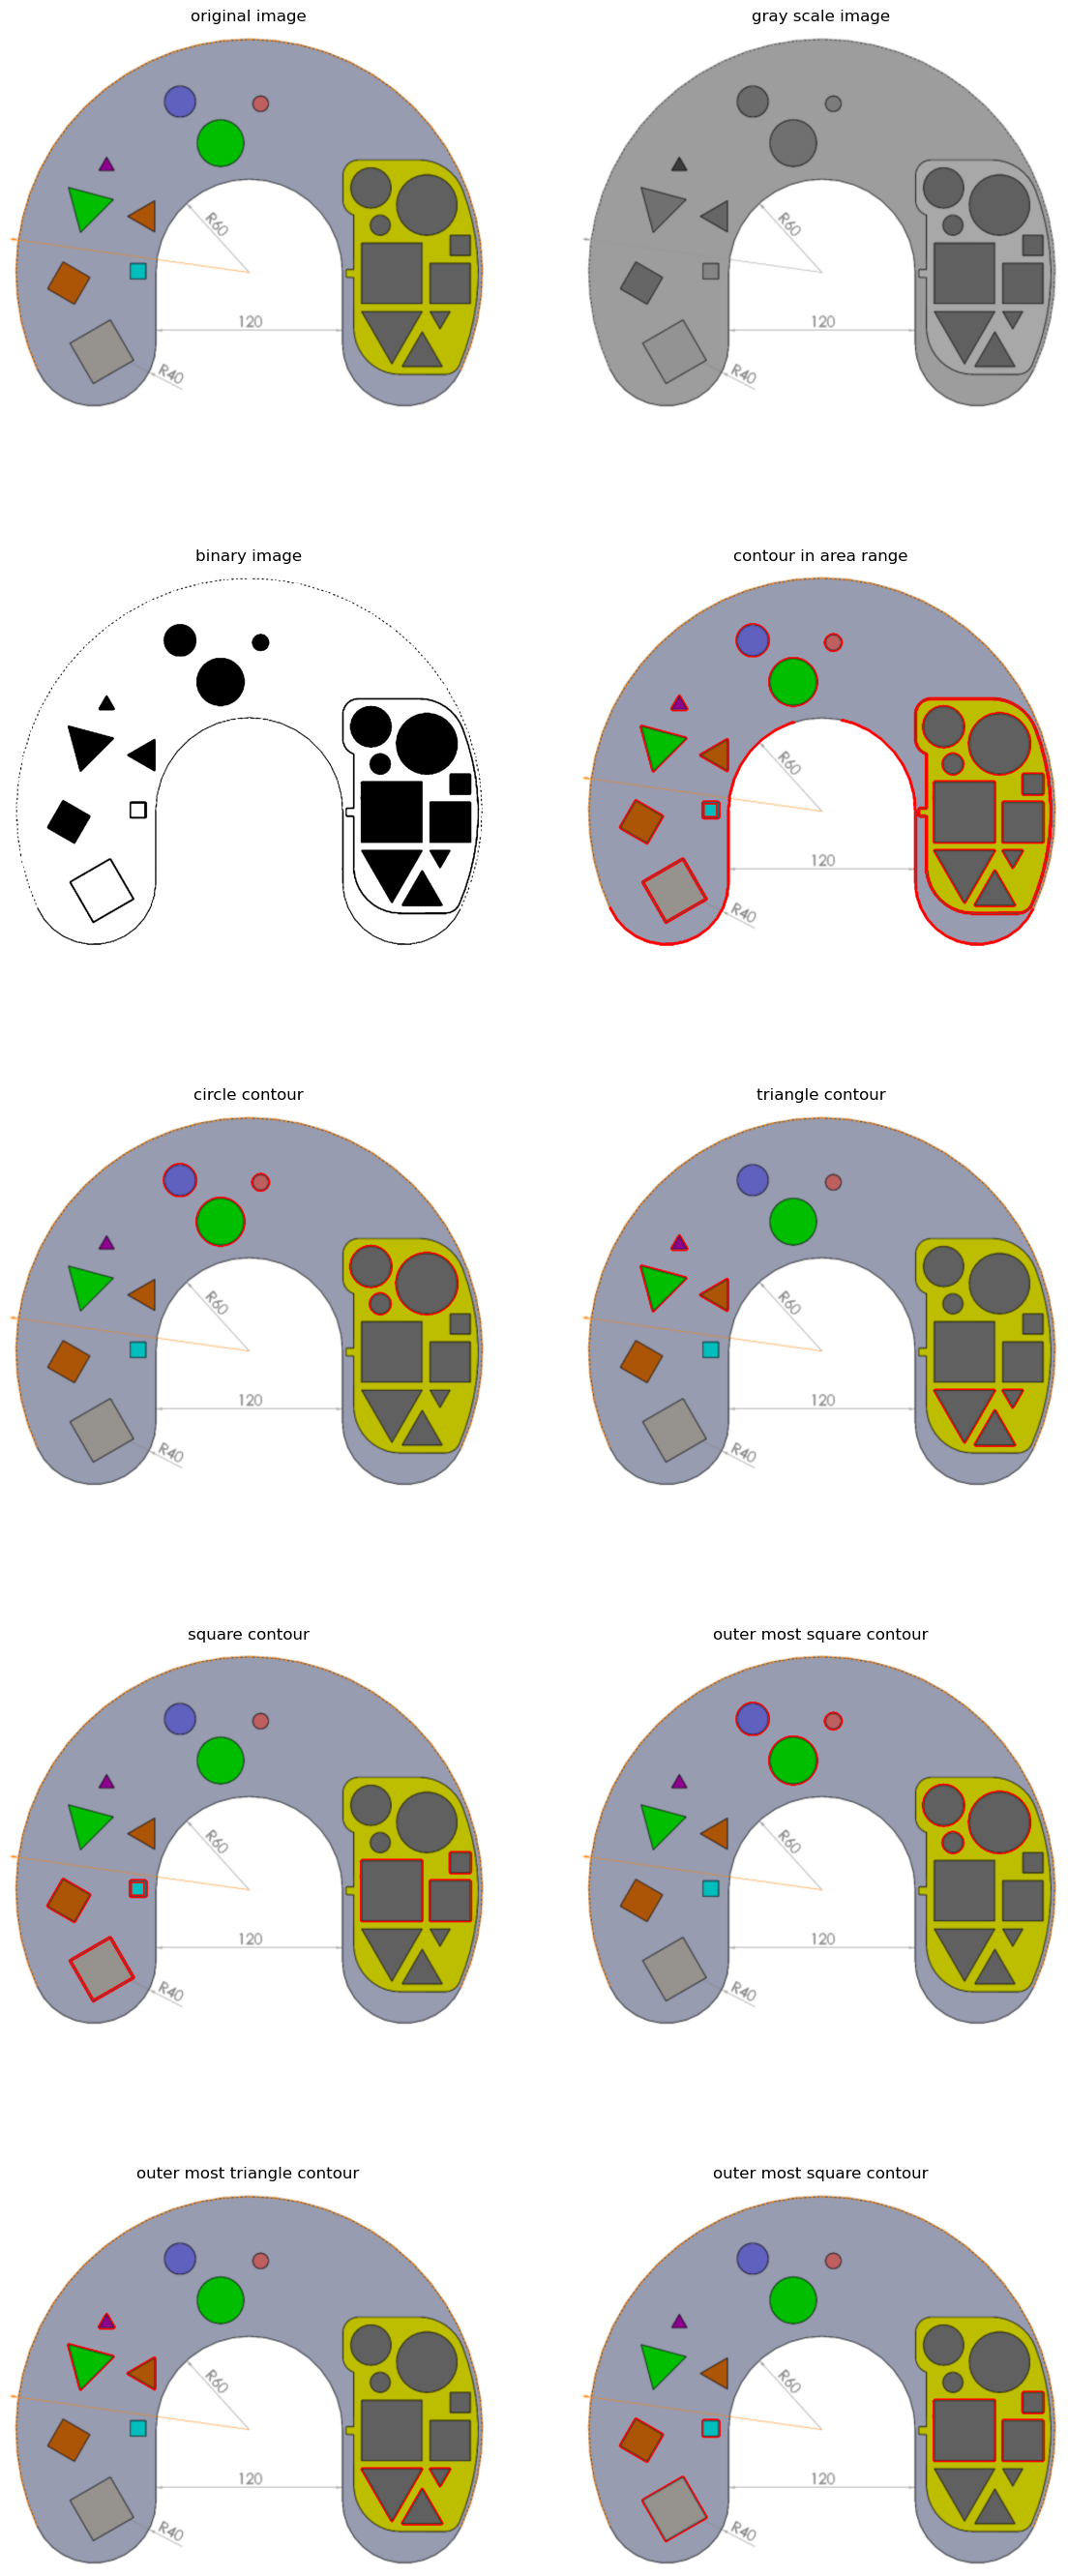

In [40]:
# create image plotter object
imagePlotter = ImagePlotter( 7, 7, 2 )

# reading image
originalImage = cv2.imread( 'field_image_from_manual.png' )

# add original image to figure
imagePlotter.addImageToPlot( originalImage, 'original image' )

# converting image into grayscale image
grayScaleImage = cv2.cvtColor( originalImage, cv2.COLOR_BGR2GRAY )

# add gray scale image to figure 
imagePlotter.addImageToPlot( grayScaleImage, 'gray scale image' )

# convert to binary image
_, binaryImage = cv2.threshold( grayScaleImage, 127, 255, cv2.THRESH_BINARY )

# add binary image to figure 
imagePlotter.addImageToPlot( binaryImage, 'binary image' )

# finding contours from binary image
contourList, _ = cv2.findContours( binaryImage, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE )

# init contour storage
contourStorageObj = ContourStorage( contourList )

# filter contour only in area range
contourObjInAreaRangeList = contourStorageObj.filterContoursOnlyInAreaRange( 1000, 300000 )

# # filter contour by area
# contourInAreaRangeList = filterContoursOnlyInAreaRange( contourList, 1000, 300000 )

# copy original image to draw contour in area range
originalImageForDrawContourInAreaRange = originalImage.copy()

# loop through contour in area range
for contourObj in contourObjInAreaRangeList:
	
	# using drawContours() function
	cv2.drawContours( originalImageForDrawContourInAreaRange, [ contourObj.contour ], 0, (0, 0, 255), 3 )

# add original image with contour in area range to figure 
imagePlotter.addImageToPlot( originalImageForDrawContourInAreaRange, 'contour in area range' )

# copy original image to draw circle contour
originalImageForDrawCircleContour = originalImage.copy()

# copy original image to draw triangle contour
originalImageForDrawTriangleContour = originalImage.copy()

# copy original image to draw square contour
originalImageForDrawSquareContour = originalImage.copy()

# # loop through contour in area range
# for contour in contourInAreaRangeList:

# 	# this is circle contour
# 	if isCircleContour( contour, 4, 6 ):
	
# 		# draw contour in image for circle contour
# 		cv2.drawContours( originalImageForDrawCircleContour, [ contour ], 0, (0, 0, 255), 3 )
# 		continue

# 	# this is triangle contour
# 	elif isTriangleContour( contour, 5 ):

# 		# draw contour in image for triangle contour
# 		cv2.drawContours( originalImageForDrawTriangleContour, [ contour ], 0, (0, 0, 255), 3 )
# 		continue

# 	# this is square contour
# 	elif isSquareContour( contour, 4, 5 ):

# 		# store this contour
# 		squareContourList.append( contour )

# 		# draw contour in image for square contour
# 		cv2.drawContours( originalImageForDrawSquareContour, [ contour ], 0, (0, 0, 255), 3 )
# 		continue

# classify contour object by its shape
contourStorageObj.classifyContourObjByShape()

print( contourStorageObj.circleContourObjList )
print( contourStorageObj.triangleContourObjList )
print( contourStorageObj.squareContourObjList )

# loop through each circle contour
for circleContourObj in contourStorageObj.circleContourObjList:

	# draw contour 
	cv2.drawContours( originalImageForDrawCircleContour, [ circleContourObj.contour ], 0, (0, 0, 255), 3 )

# add original image with circle contour 
imagePlotter.addImageToPlot( originalImageForDrawCircleContour, 'circle contour' )

# loop through each circle contour
for triangleContourObj in contourStorageObj.triangleContourObjList:

	# draw contour 
	cv2.drawContours( originalImageForDrawTriangleContour, [ triangleContourObj.contour ], 0, (0, 0, 255), 3 )

# add original image with triangle contour 
imagePlotter.addImageToPlot( originalImageForDrawTriangleContour, 'triangle contour' )

# loop through each circle contour
for squareContourObj in contourStorageObj.squareContourObjList:

	# draw contour 
	cv2.drawContours( originalImageForDrawSquareContour, [ squareContourObj.contour ], 0, (0, 0, 255), 3 )

# add original image with square contour 
imagePlotter.addImageToPlot( originalImageForDrawSquareContour, 'square contour' )

# # outer most square contour storage
# outerMostSquareContourList = []

# copy original image to draw outer most circle contour
originalImageForDrawOuterMostCircleContour = originalImage.copy()

# copy original image to draw outer most triangle contour
originalImageForDrawOuterMostTriangleContour = originalImage.copy()

# copy original image to draw outer most square contour
originalImageForDrawOuterMostSquareContour = originalImage.copy()

# # loop each square contour
# for squareContour in squareContourList:

# 	# print( f'squareContour {squareContour}' )

# 	# this is the outer most contour
# 	if isOuterMostContour( squareContour, squareContourList ):

# 		# store it
# 		outerMostSquareContourList.append( squareContour )

# 		# draw contour in image for outer most square contour
# 		cv2.drawContours( originalImageForDrawOuterMostSquareContour, [ squareContour ], 0, (0, 0, 255), 3 )

# filter only outer most circle contour object
contourStorageObj.outerMostCircleContourObjList = contourStorageObj.filterOnlyOuterMostContourObj( contourStorageObj.circleContourObjList, 4 )

# loop through each outer most circle contour object
for circleContourObj in contourStorageObj.outerMostCircleContourObjList:

	# draw contour 
	cv2.drawContours( originalImageForDrawOuterMostCircleContour, [ circleContourObj.contour ], 0, (0, 0, 255), 3 )

# add original image with outer most circle contour to figure
imagePlotter.addImageToPlot( originalImageForDrawOuterMostCircleContour, 'outer most circle contour' )

# filter only outer most triangle contour object
contourStorageObj.outerMostTriangleContourObjList = contourStorageObj.filterOnlyOuterMostContourObj( contourStorageObj.triangleContourObjList, 5 )

# loop through each outer most triangle contour object
for triangleContourObj in contourStorageObj.outerMostTriangleContourObjList:

	# draw contour 
	cv2.drawContours( originalImageForDrawOuterMostTriangleContour, [ triangleContourObj.contour ], 0, (0, 0, 255), 3 )

# add original image with outer most triangle contour to figure
imagePlotter.addImageToPlot( originalImageForDrawOuterMostTriangleContour, 'outer most triangle contour' )

# filter only outer most square contour object
contourStorageObj.outerMostSquareContourObjList = contourStorageObj.filterOnlyOuterMostContourObj( contourStorageObj.squareContourObjList, 4 )

# loop through each outer most square contour object
for squareContourObj in contourStorageObj.outerMostSquareContourObjList:

	# draw contour 
	cv2.drawContours( originalImageForDrawOuterMostSquareContour, [ squareContourObj.contour ], 0, (0, 0, 255), 3 )

# add original image with outer most square contour to figure
imagePlotter.addImageToPlot( originalImageForDrawOuterMostSquareContour, 'outer most square contour' )

# show figure
imagePlotter.plotAndShowAllImage()

In [41]:
# def filterContoursOnlyInAreaRange( contourList, minArea=0, maxArea=0 ):
# 	''' - get only contour in area range

# 		ARGS:
# 			- contourList ( list )
# 			- minArea ( int )
# 			- maxArea ( int )

# 		RETURN:
# 			- contourListInAreaRange ( list )
# 	'''

# 	# contour in area range storage
# 	contourListInAreaRange = []

# 	# loop through each contour
# 	for contour in contourList:

# 		# calculate contour area
# 		contourArea = cv2.contourArea( contour )

# 		# this contour is in range
# 		if minArea <= contourArea <= maxArea:
			
# 			# store it
# 			contourListInAreaRange.append( contour )
# 	return contourListInAreaRange

# def approximatePolygonOfContour( contour, epsilonPercent ):
# 	''' - approximate polygon of contour to be a rougher shape

# 		- mainly used for shape analysis

# 		- usually set epsilon parameter to 1 - 5 % of contour's perimeter
# 	'''

# 	# calculate contour perimeter
# 	contourPerimeter = cv2.arcLength( contour, True )

# 	# approximate curve of contour
# 	approximatedPointList = cv2.approxPolyDP( contour,  epsilonPercent / 100 * contourPerimeter, True )
# 	return approximatedPointList

# def isCircleContour( contour, epsilonPercent, errorPercent ):
# 	''' - check if this is a circle contour

# 		- this contour in circle if:
# 			- approximate point is more than5
# 			- bounding box has square aspect ratio
# 	'''

# 	# calculate approximation curve of contour
# 	approximatedPointList = approximatePolygonOfContour( contour, epsilonPercent  )

# 	# contour has polygon approximation point more than 5
# 	if len( approximatedPointList ) > 5:

# 		# calculate approximation polygon bounding box
# 		( xPosition, yPosition, boundingBoxWidth, boundingBoxHeight ) = cv2.boundingRect( approximatedPointList )
		
# 		# calculate aspect ratio of bounding box
# 		boundingBoxAspectRatio = boundingBoxWidth / boundingBoxHeight

# 		# calculate acceptable error
# 		acceptableError = errorPercent / 100 

# 		# this bounding box is square
# 		if 1 - acceptableError <= boundingBoxAspectRatio <= 1 + acceptableError:
			
# 			# this contour is circle
# 			return True
		
# 	# this contour is not circle
# 	return False

# def isTriangleContour( contour, epsilonPercent ):
# 	''' - check if this is a triangle shape

# 		- this contour is triangle if:
# 			- it approximation curve has 3 points 
# 	''' 

# 	# calculate approximation curve of contour
# 	approximatedPointList = approximatePolygonOfContour( contour, epsilonPercent  )

# 	# this is triangle shape contour
# 	if len( approximatedPointList ) == 3:
# 		return True
	
# 	# this is not a triangle contour
# 	return False

# def isSquareContour( contour, epsilonPercent, errorPercent ):
# 	''' - check if this contour is square shape

# 		- this contour is square contour if:
# 			- its approximation curve has 4 points
# 			- its bounding box has an aspect ration close to 1
# 	'''

# 	# calculate approximation curve of contour
# 	approximatedPointList = approximatePolygonOfContour( contour, epsilonPercent  )

# 	# contour has polygon approximation point equal to 4
# 	if len( approximatedPointList ) == 4:

# 		# calculate approximation polygon bounding box
# 		( xPosition, yPosition, boundingBoxWidth, boundingBoxHeight ) = cv2.boundingRect( approximatedPointList )
		
# 		# calculate aspect ratio of bounding box
# 		boundingBoxAspectRatio = boundingBoxWidth / boundingBoxHeight

# 		# calculate acceptable error
# 		acceptableError = errorPercent / 100 

# 		# this bounding box is square
# 		if 1 - acceptableError <= boundingBoxAspectRatio <= 1 + acceptableError:
			
# 			# this is square contour
# 			return True
		
# 	# this contour is not square
# 	return False

# def isOuterMostContour( contour, otherContourList ):
# 	''' - check to see if this contour is NOT inside any of the other contour
# 	'''

# 	# approximate polygon of contour
# 	approximatedPolygonList = approximatePolygonOfContour( contour, 4 )

# 	# loop through each point in contour
# 	for otherContour in otherContourList:

# 		# loop each point in approximated polygon
# 		for point in approximatedPolygonList:

# 			pointTuple = ( int( point[ 0 ][ 0 ] ), int( point[ 0 ][ 1 ] ) )

# 			# point is inside other approximated polygon
# 			if cv2.pointPolygonTest( otherContour, pointTuple, False ) > 0:
				
# 				# this is NOT the outer most contour
# 				return False

# 	# this is the outer most contour
# 	return True